# Detection of stages: Light, Deep, REM, Wake Movement

Database source: 
    
    Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/content/101/23/e215.full]; 2000 (June 13).


In [1]:
from __future__ import division
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as ss
import seaborn as sns
from scipy.ndimage import convolve1d
import itertools
import sleep_utils as su

# import psycopg2
import datetime  
import time 
import wfdb
import glob

from biosppy.signals import ecg

%matplotlib inline
sns.set()
pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

## Load a file from database

In [2]:
data_dir = '../data/PSG_database/'

co2_sig = []
ppg_sig = []

filenames = []

sleep_data_sigs = {}
sleep_data_fields = {}

data_keys = []
for fname in glob.iglob(data_dir + '/*.dat'):#, recursive=True):
    # filename manipulation
    base = os.path.basename(fname)
    key = os.path.splitext(base)[0]
    data_keys.append(key)
    
    # load data
    sig, fields=wfdb.rdsamp(data_dir+key)
    sleep_data_sigs[key] = sig
    sleep_data_fields[key] = fields

In [3]:
ann_index = {}
ann_labels = {}

set_stages = set()
for key in data_keys:
    annotation = wfdb.rdann(data_dir + key, 'st')
    ann_index_sig = annotation[0]
    ann_label_sig = annotation[5]
    label_filt = [(x, y) for x, y in zip(ann_index_sig, ann_label_sig) if x >1 ]
    unzipped = zip(*label_filt)
    ann_index[key] = unzipped[0]
    ann_labels[key] = unzipped[1]


In [4]:
resp_data_set = {}
ecg_data_set = {}
time_data_set = {}
annot_data_set = {}

fs = 250
dec_prec = len(str(1/fs).split('.')[1])

for key in data_keys:
    
    resp_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('Resp')]
    ecg_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('ECG')]
    time_data_set[key] = np.arange(0, len(resp_data_set[key]))/fs

    # Note: Only the first character of the annotation was taken as label
    # Example: 1, 2, 3, 4, R, W, M
    stages_list = [x.rsplit(' ')[0][0] for x in ann_labels[key]]

    annot_data_set[key] = stages_list


#### *Annotations*

Stages:
   * W: subject is awake
   * 1: sleep stage 1
   * 2: sleep stage 2
   * 3: sleep stage 3
   * 4: sleep stage 4
   * R: REM sleep
   
Other descriptions:
   * H: Hypopnea
   * HA: Hypopnea with arousal
   * OA: Obstructive apnea
   * X: Obstructive apnea with arousal
   * CA: Central apnea
   * CAA: Central apnea with arousal
   * L: Leg movements
   * LA: Leg movements with arousal
   * A: Unspecified arousal
   * MT: Movement time

## Get Features

### I. Previous sleep stage

Note: Get features for every window of data

In [5]:
win_dur = 30 # duration of window, unit: seconds, size of one epoch 
win_size = fs*win_dur # length of window
win_step = 1 # duration by which the window slides, unit: seconds
win_int = win_step*fs # length by which the window slides

In [6]:
feature_prev_stage = {}
feature_prev_stage_light = {}
feature_prev_stage_deep = {}
feature_prev_stage_rem = {}
feature_prev_stage_wake = {}
feature_prev_stage_move = {}

for key in data_keys:
    previous = annot_data_set[key][1:]
    prev_stage = [np.nan] + previous
    feature_prev_stage[key] = {'_feat' : prev_stage}
    
    # NREM-light or not
    feature_prev_stage_light[key] = {'_feat' : [np.nan] +map(lambda x: 0 if x not in ['1', '2'] else 1, previous)}
    
    # NREM-deep or not
    feature_prev_stage_deep[key] = {'_feat' : [np.nan] +map(lambda x: 0 if x not in ['1', '2'] else 1, previous)}
    
    # REM or not
    feature_prev_stage_rem[key] = {'_feat' : [np.nan] + map(lambda x: 0 if x!= 'R' else 1,previous)}
    
    # Wake or not
    feature_prev_stage_wake[key] = {'_feat' :[np.nan] + map(lambda x: 0 if x!= 'W' else 1,previous)}
    
    # Wake or not
    feature_prev_stage_move[key] = {'_feat' :[np.nan] + map(lambda x: 0 if x!= 'M' else 1,previous)}


### II. Respiration signal

Divide respiration data per 30-second epoch. 

In [7]:
# Respiratory frequency range 
min_normrange = 4/60 # unit: cycles per second
max_normrange = 65/60 # unit: cycles per second

resp_data_set_epochs = {}

for key in data_keys:
    resp_sig = resp_data_set[key]
    fft_resp = np.fft.fft(resp_sig)
    fft_freqs = np.fft.fftfreq(len(resp_sig), 1/fs)
    
    # Remove frequencies which are outside the expected range
    fft_resp[abs(fft_freqs) < min_normrange] = 0
    fft_resp[abs(fft_freqs) > max_normrange] = 0
    
    resp_filt_sig = np.real(np.fft.ifft(fft_resp))
    time_sig = np.arange(len(resp_sig))/fs

    # Divide into windows
    resp_windows = su.divide_to_epochs(resp_filt_sig, ann_index[key], win_dur, fs)
    time_windows = su.divide_to_epochs(time_sig, ann_index[key], win_dur, fs)
    
    resp_data_set_epochs[key] = pd.DataFrame({'resp': list(resp_windows), '_time': list(time_windows)})


#### II.1 Respiration rate
*Frequency corresponding to the highest peak in the epoch's power spectrum (unit: breaths/minute)*

In [8]:
feature_resp_rate = {}
# feature_resp_rate_fd = {}
# feature_resp_rate_sd = {}

for key in data_keys:
    resp_data = resp_data_set_epochs[key]
    resp_data['power_spectrum'] = resp_data.resp.apply(lambda x: ss.periodogram(x, fs=fs))
    
    # Compute respiration rate
    resp_data['resp_rate'] = resp_data.power_spectrum.apply(lambda x: (x[0])[np.argmax(x[1])]*60)

    feature_resp_rate[key] = {'_feat' : resp_data.resp_rate.values}


#### II.2 Histogram of Respiration data
Use the counts for each bin of the magnitude histogram.

In [9]:
nbins = 5

feature_hist_resp = {}

for key in data_keys:
#     print("Computing for "+ key + "...")
    resp_data = resp_data_set_epochs[key]

    hist_windows = resp_data.resp.apply(lambda x: np.histogram(x, bins=nbins, normed=True)[0])
    feature_hist_resp[key] = {'_feat' : (np.asarray(hist_windows))}

#### II.3 Ratio of standard deviation and mean of magnitude

In [10]:
feature_mean_vs_std_resp = {}

for key in data_keys:
#     print("Computing for "+ key + "...")
    resp_data = resp_data_set_epochs[key]

    mean_vs_std = resp_data.resp.apply(lambda x: (np.mean(x)/np.std(x)))
    feature_mean_vs_std_resp[key] = {'_feat' : list(mean_vs_std)}

### III. ECG signal

Divide ECG data per 30-second epoch. 

In [11]:
ecg_data_set_epochs = {}

for key in data_keys:
    ecg_sig = ecg_data_set[key]
    time_sig = np.arange(len(ecg_sig))/fs

    # Divide into windows
    ecg_windows = su.divide_to_epochs(ecg_sig, ann_index[key], win_dur, fs)
    time_windows = su.divide_to_epochs(time_sig, ann_index[key], win_dur, fs)
    
    ecg_data_set_epochs[key] = pd.DataFrame({'ecg': list(ecg_windows), '_time': list(time_windows)})


#### III.1 Heart rate
*Reciprocal of the mean R-R interval in an epoch (unit: beats/minute)*


#### III.2 Heart rate variability
*Standard deviation of the R-R intervals in an epoch (unit: milliseconds)*


In [12]:
feature_heart_rate = {}
feature_heart_rate_var = {}

for key in data_keys:
    ecg_data = ecg_data_set_epochs[key]
    
    # Get time corresponding to R peaks
    ecg_data['r_peaks'] = ecg_data.ecg.apply(lambda x: ecg.hamilton_segmenter(x, sampling_rate=250)['rpeaks'])
    ecg_data['r_time'] = ecg_data.apply(lambda x: list(x._time[x.r_peaks]), axis = 1)
    
    # Compute heart rate
    ecg_data['heart_rate'] = ecg_data.r_time.apply(lambda x: su.heart_rate(np.array(x))*60)
    ecg_data['window_time'] = ecg_data['_time'].apply(lambda x: x[-1])
        
    # Compute heart rate variability
    ecg_data['heart_rate_var'] = ecg_data.r_time.apply(lambda x: su.heart_rate_var(np.array(x))*1000)
    
    feature_heart_rate[key] = {'_feat' : ecg_data.heart_rate.values}
    feature_heart_rate_var[key] = {'_feat' : ecg_data.heart_rate_var.values}

#### III.3 Histogram of ECG data
Use the counts for each bin of the magnitude histogram.

In [13]:
feature_hist_ecg = {}

for key in data_keys:
#     print("Computing for "+ key + "...")
    ecg_data = ecg_data_set_epochs[key]

    hist_windows = ecg_data.ecg.apply(lambda x: np.histogram(x, bins=nbins, normed=True)[0])
    feature_hist_ecg[key] = {'_feat' : (np.asarray(hist_windows))}

#### III.4 Ratio of standard deviation and mean of magnitude

In [14]:
feature_mean_vs_std_ecg = {}

for key in data_keys:
#     print("Computing for "+ key + "...")
    ecg_data = ecg_data_set_epochs[key]

    mean_vs_std = ecg_data.ecg.apply(lambda x: (np.mean(x)/np.std(x)))
    feature_mean_vs_std_ecg[key] = {'_feat' : list(mean_vs_std)}

## Compile features 
Combine features computed across all patients

In [15]:
# # features = [feature_prev_stage, feature_resp_rate, feature_hist_resp, 
# #             feature_heart_rate, feature_heart_rate_var, feature_hist_ecg, 
# #             feature_mean_vs_std_resp, feature_mean_vs_std_ecg]

# features = [feature_resp_rate, feature_hist_resp, 
#             feature_heart_rate, feature_heart_rate_var, feature_hist_ecg, 
#             feature_mean_vs_std_resp, feature_mean_vs_std_ecg]


# f_merge = []
# for f in features:
#     fm = []
#     for key in data_keys:
#         fm += list(f[key]['_feat'])
#     f_merge.append(np.reshape(fm, [len(fm), -1]))
    
# sleep_features = np.hstack(f_merge)
# # sleep_features[np.where(sleep_features == '1')] = 1
# # sleep_features[np.where(sleep_features == '2')] = 2
# # sleep_features[np.where(sleep_features == '3')] = 3
# # sleep_features[np.where(sleep_features == '4')] = 3
# # sleep_features[np.where(sleep_features == 'R')] = 4
# # sleep_features[np.where(sleep_features == 'W')] = 5
# # sleep_features[np.where(sleep_features == 'M')] = 6

# merge_labels = np.hstack([annot_data_set[key] for key in data_keys])

# merge_labels[np.where(merge_labels == '1')] = 1
# merge_labels[np.where(merge_labels == '2')] = 2
# merge_labels[np.where(merge_labels == '3')] = 3
# merge_labels[np.where(merge_labels == '4')] = 3
# merge_labels[np.where(merge_labels == 'R')] = 4
# merge_labels[np.where(merge_labels == 'W')] = 5
# merge_labels[np.where(merge_labels == 'M')] = 6

In [16]:
# features = [feature_prev_stage, feature_resp_rate, feature_hist_resp, 
#             feature_heart_rate, feature_heart_rate_var, feature_hist_ecg, 
#             feature_mean_vs_std_resp, feature_mean_vs_std_ecg]

features = [feature_prev_stage_light, feature_prev_stage_deep, feature_prev_stage_rem, 
            feature_prev_stage_wake, feature_prev_stage_move,
            feature_resp_rate, feature_hist_resp, feature_heart_rate, 
            feature_heart_rate_var, feature_hist_ecg, 
            feature_mean_vs_std_resp, feature_mean_vs_std_ecg]


f_merge = []
for f in features:
    fm = []
    for key in data_keys:
        fm += list(f[key]['_feat'])
    f_merge.append(np.reshape(fm, [len(fm), -1]))
    
sleep_features = np.hstack(f_merge)

merge_labels = np.hstack([annot_data_set[key] for key in data_keys])

merge_labels[np.where(merge_labels == '1')] = 1
merge_labels[np.where(merge_labels == '2')] = 2
merge_labels[np.where(merge_labels == '3')] = 3
merge_labels[np.where(merge_labels == '4')] = 3
merge_labels[np.where(merge_labels == 'R')] = 4
merge_labels[np.where(merge_labels == 'W')] = 5
merge_labels[np.where(merge_labels == 'M')] = 6


In [17]:
sleep_features = np.array(sleep_features, dtype = float)
sleep_data = sleep_features[np.isfinite(sleep_features).all(axis=1)]
sleep_labels = np.reshape(merge_labels, [len(merge_labels), 1])[np.isfinite(sleep_features).all(axis=1)]

## Classify

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

/Users/eventura/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
## Feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [21]:
sleep_data_scaled = StandardScaler().fit_transform(sleep_data)
train_set, test_set, train_label, test_label = train_test_split(sleep_data_scaled, sleep_labels, test_size=0.33, random_state=42)

train_label = np.ndarray.flatten(train_label).astype(float)
test_label = np.ndarray.flatten(test_label).astype(float)

In [22]:
names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "AdaBoost",
         "Naive Bayes", "QDA", "Linear SVM", "RBF SVM",]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(), 
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1)]

In [23]:
for i in np.arange(len(classifiers)):
    print('Training ' + names[i])
    clf = classifiers[i]
    clf.fit(train_set, np.ndarray.flatten(train_label))
    prediction = clf.predict(test_set)
    print(names[i], accuracy_score(test_label, prediction))
    print(confusion_matrix(test_label, prediction, labels = np.unique(test_label)))
    print('\n')
    

Training Nearest Neighbors
('Nearest Neighbors', 0.87332339791356184)
[[ 337  273    0    0    0    0]
 [ 150 1092    0    0    1    0]
 [   0    0  211    0    1    0]
 [   0    0    0  230    0    0]
 [   0    0    0    0 1054    0]
 [   0    0    0    0    0    6]]


Training Decision Tree
('Decision Tree', 0.8461997019374069)
[[ 284  326    0    0    0    0]
 [ 190 1053    0    0    0    0]
 [   0    0  212    0    0    0]
 [   0    0    0  230    0    0]
 [   0    0    0    0 1054    0]
 [   0    0    0    0    0    6]]


Training Random Forest
('Random Forest', 0.84679582712369594)
[[ 237  370    0    0    3    0]
 [  80 1161    0    0    2    0]
 [   0    4  163    0   45    0]
 [   0    0    0  223    7    0]
 [   0    0    0    0 1054    0]
 [   0    0    1    0    2    3]]


Training AdaBoost
('AdaBoost', 0.75499254843517138)
[[   0  610    0    0    0    0]
 [   0 1243    0    0    0    0]
 [   0  212    0    0    0    0]
 [   0    0    0  230    0    0]
 [   0    0    0    

/Users/eventura/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


('Linear SVM', 0.84053651266766016)
[[ 232  378    0    0    0    0]
 [ 157 1086    0    0    0    0]
 [   0    0  212    0    0    0]
 [   0    0    0  230    0    0]
 [   0    0    0    0 1054    0]
 [   0    0    0    0    0    6]]


Training RBF SVM
('RBF SVM', 0.83189269746646799)
[[ 260  319    0    0   31    0]
 [  89 1127    0    0   27    0]
 [   0    0  182    0   30    0]
 [   0    0    0  168   62    0]
 [   0    0    0    0 1054    0]
 [   0    0    0    0    6    0]]




### Feature selection and classification

In [24]:
num_feats = np.arange(np.array(train_set, dtype = float).shape[1], 0, -1)
accuracies = np.zeros([len(classifiers), len(num_feats)])

In [25]:
for i in range(len(num_feats)):
    feat_filter = SelectKBest(f_regression, k=num_feats[i])
    feat_filter.fit(np.array(train_set, dtype = float), train_label)
    train_set_filt = feat_filter.transform(train_set.astype(float))
    test_set_filt = feat_filter.transform(test_set.astype(float))

    selected = feat_filter.transform(np.reshape(np.arange(np.array(train_set, dtype = float).shape[1]), [1, -1]))
    select_scores = feat_filter.transform(np.reshape(feat_filter.scores_, [1, -1]))
    print('Selected {} features ranked accdg to score: \t {}'.format(num_feats[i], selected[0][np.fliplr(select_scores.argsort())[0]]))
    
    for j in range(len(classifiers)):
        clf = classifiers[j]
        clf.fit(train_set_filt, train_label)
        prediction = clf.predict(test_set_filt)
        
        accuracies[j, i] = accuracy_score(test_label, prediction)
#         print('\t {:>16} \t : {}'.format(names[j], selected[0][np.fliplr(select_scores.argsort())[0]]))

Selected 20 features ranked accdg to score: 	 [ 0  1  3  5  2 12 11  9 10  4  6  7 15  8 17 16 19 18 13 14]
Selected 19 features ranked accdg to score: 	 [ 0  1  3  5  2 12 11  9 10  4  6  7 15  8 17 16 19 18 13]
Selected 18 features ranked accdg to score: 	 [ 0  1  3  5  2 12 11  9 10  4  6  7 15  8 17 16 19 18]
Selected 17 features ranked accdg to score: 	 [ 0  1  3  5  2 12 11  9 10  4  6  7 15  8 17 16 19]
Selected 16 features ranked accdg to score: 	 [ 1  0  3  5  2 12 11  9 10  4  6  7 15  8 17 16]
Selected 15 features ranked accdg to score: 	 [ 1  0  3  5  2 12 11  9 10  4  6  7 15  8 17]
Selected 14 features ranked accdg to score: 	 [ 1  0  3  5  2 12 11  9 10  4  6  7 15  8]
Selected 13 features ranked accdg to score: 	 [ 1  0  3  5  2 12 11  9 10  4  6  7 15]
Selected 12 features ranked accdg to score: 	 [ 1  0  3  5  2 12 11  9 10  4  6  7]
Selected 11 features ranked accdg to score: 	 [ 1  0  3  5  2 12 11  9 10  4  6]
Selected 10 features ranked accdg to score: 	 [ 1  0  3

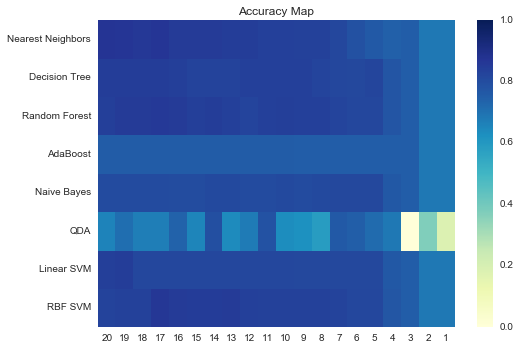

In [26]:
from seaborn import heatmap

# plt.figure(figsize=[8, 7])
heatmap(accuracies, vmin=0, vmax = 1, yticklabels = names, xticklabels=num_feats, cmap="YlGnBu")
plt.title('Accuracy Map')